In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('BTC-USD.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head()

/var/folders/9c/70_7fvpj7qd_vxq_xtr8_0580000gn/T/ipykernel_42916/987262833.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


,High,Low,Close,Volume,SPY,ETH,HBAR
Date,,,,,,,
2020-01-01,7254.330566,7174.944336,7200.174316,1.856566e+10,324.869995,130.802002,0.010439
2020-01-02,7212.155273,6935.270020,6985.470215,2.080208e+10,322.410004,127.410179,0.010080
2020-01-03,7413.715332,6914.996094,7344.884277,2.811148e+10,323.640015,134.171707,0.010383
2020-01-04,7427.385742,7309.514160,7410.656738,1.844427e+10,322.730011,135.069366,0.011203
2020-01-05,7544.497070,7400.535645,7411.317383,1.972507e+10,324.450012,136.276779,0.011760


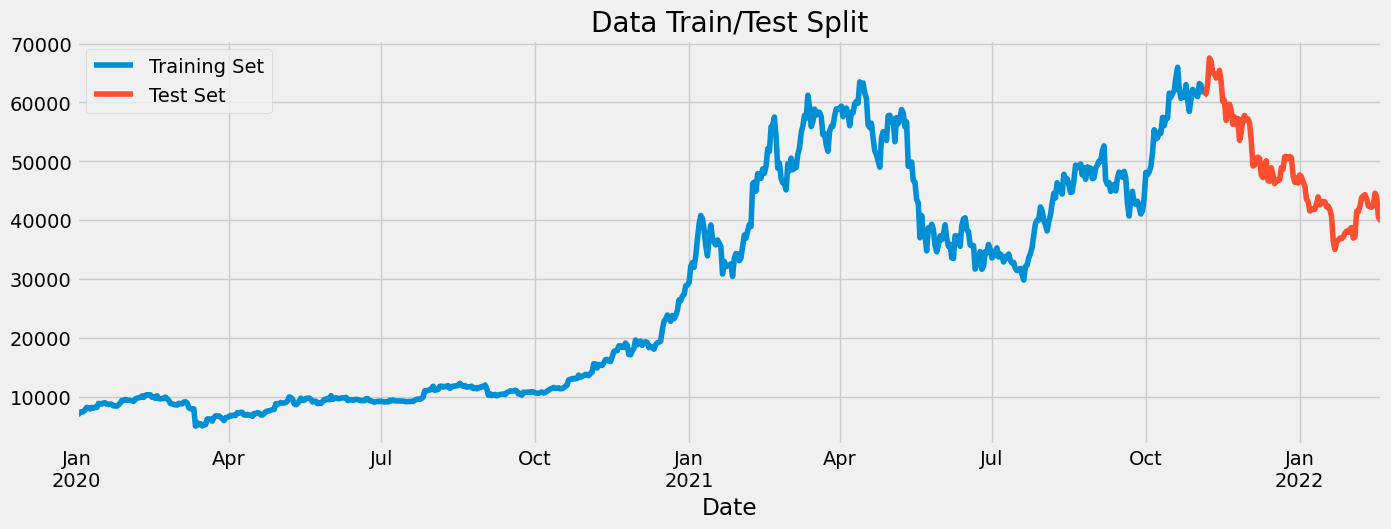

In [3]:
# Split data into training and testing sets by date cutoff
train = df.loc[df.index < '11-05-2021']
test = df.loc[df.index >= '11-05-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train['Close'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Close'].plot(ax=ax, label='Testing Set')

ax.legend(['Training Set', 'Test Set'])
plt.show()

In [4]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [5]:
df.head()

,High,Low,Close,Volume,SPY,ETH,HBAR,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,,,,,,
2020-01-01,7254.330566,7174.944336,7200.174316,1.856566e+10,324.869995,130.802002,0.010439,2,1,1,2020,1
2020-01-02,7212.155273,6935.270020,6985.470215,2.080208e+10,322.410004,127.410179,0.010080,3,1,1,2020,2
2020-01-03,7413.715332,6914.996094,7344.884277,2.811148e+10,323.640015,134.171707,0.010383,4,1,1,2020,3
2020-01-04,7427.385742,7309.514160,7410.656738,1.844427e+10,322.730011,135.069366,0.011203,5,1,1,2020,4
2020-01-05,7544.497070,7400.535645,7411.317383,1.972507e+10,324.450012,136.276779,0.011760,6,1,1,2020,5


In [6]:
# Define the features to be used and the target variable to predict

FEATURES = ['SPY','ETH','HBAR']
TARGET = 'Close'

In [7]:
# Format feature/target for train/test in the manner XGBoost expects it to be in

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [8]:
# Run actual XGBoost Regressor with specifications of parameters

reg = xgb.XGBRegressor(
    n_estimators=80,
    learning_rate=0.15,
    max_depth=10,  # You can experiment with different values
    min_child_weight=1,  # You can experiment with different values
    subsample=0.8,  # You can experiment with different values
    colsample_bytree=0.8,  # You can experiment with different values
    reg_alpha=0.01,  # You can experiment with different values
    reg_lambda=1,  # You can experiment with different values
    gamma=0,  # You can experiment with different values
    objective='reg:squarederror',  # For regression tasks
    booster='gbtree',
    tree_method='auto',  # You can experiment with different values
    n_jobs=-1,  # Utilize all available cores
    random_state=42
)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose = 10)

[0]	validation_0-rmse:16263.29274	validation_1-rmse:19432.50029
[10]	validation_0-rmse:4041.93992	validation_1-rmse:6547.70043
[20]	validation_0-rmse:1402.33370	validation_1-rmse:4588.58721
[30]	validation_0-rmse:700.55607	validation_1-rmse:4275.20992
[40]	validation_0-rmse:411.34656	validation_1-rmse:4246.03935
[50]	validation_0-rmse:273.59164	validation_1-rmse:4214.54518
[60]	validation_0-rmse:195.94559	validation_1-rmse:4202.23011
[70]	validation_0-rmse:142.62695	validation_1-rmse:4199.91472
[79]	validation_0-rmse:113.44204	validation_1-rmse:4195.80248


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

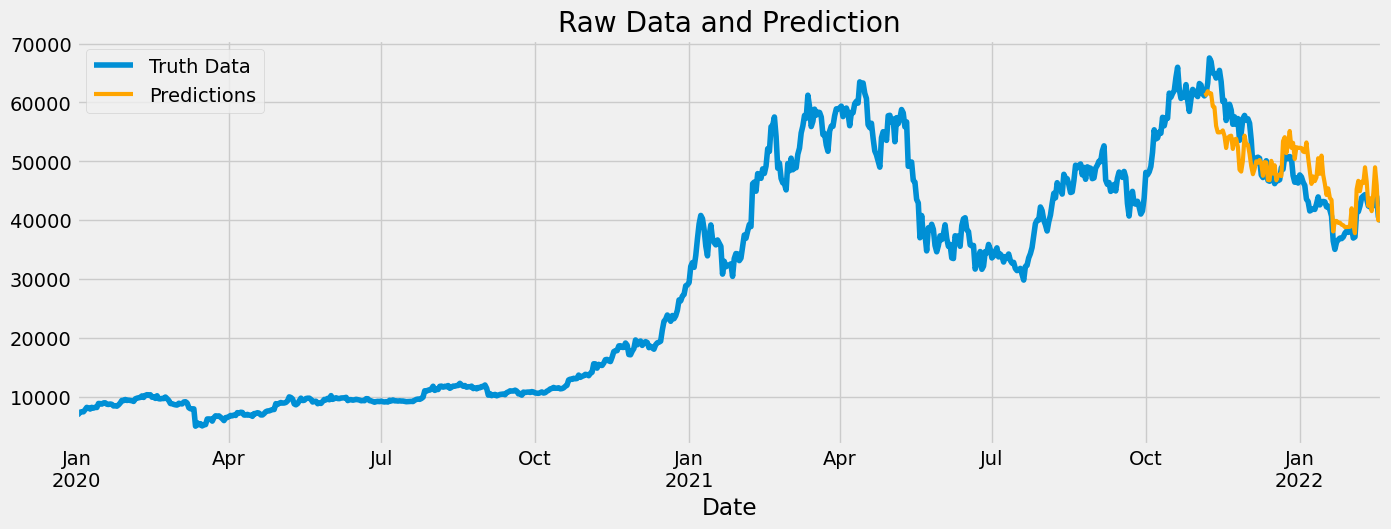

In [9]:
# Plot of actual closing price data and the XGBoost prediction from the features
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Close']].plot(figsize=(15,5))
plt.plot(df.index, df['prediction'], linestyle='-', linewidth=3, color='orange')  # Adjust linewidth and color as needed
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [10]:
mse = np.sqrt(mean_squared_error(test['Close'],test['prediction']))
mae = mean_absolute_error(test['Close'],test['prediction'])
r2 = r2_score(test['Close'],test['prediction'])

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Mean Squared Error: 4195.802476224947
Mean Absolute Error: 3427.5479701285044
R-squared score: 0.742798351555523
